In [ ]:
# OSM POINT GENERATOR
# Version: 1.0
# Author: Perez Joan
#
# This script is designed to automate the process of downloading and processing
# OpenStreetMap (OSM) street data within a user-defined geographic bounding box.
# It begins by fetching street geometries from OSM and proceeds to clean and
# filter the data to ensure consistency and remove duplicates. Once the streets
# are processed, the script generates sample points along each street segment.
# If a segment is shorter than the specified offset, no point is placed. For
# segments between the offset and offset plus the spacing distance, one point is
# placed at the center. Each street and point is assigned a unique
# identifier to maintain traceability. Additionally, point coordinates are
# converted to latitude and longitude using the WGS84 coordinate system for
# compatibility with global mapping tools. The final results—including both the
# cleaned streets and the generated points—are saved as separate layers within
# a GeoPackage file, allowing for easy reuse in GIS workflows. The user can
# fully control the spacing and offset parameters, making the script adaptable
# to various urban analysis or mapping tasks.

In [ ]:
!pip install osmnx
import os
import geopandas as gpd
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box, LineString, Point
from google.colab import drive

# ------------------------ USER PARAMETERS ------------------------
# Mount Google Drive
drive.mount('/content/drive')

# Set the case study name (e.g., 'vienna', 'nice')
case_study_name = 'nice'

# Define Bounding Box (WGS84 - EPSG:4326)
# e.g. 16.2300, 16.2500 & 48.1900, 48.2200 for vienna (below is for nice)
xMin, xMax = 7.3020, 7.3250
yMin, yMax = 43.7350, 43.7650

# Projected CRS (e.g. 'EPSG:32633' for vienna, 'EPSG:2154' for nice)
projected_crs = 'EPSG:2154'

# Set the distance between generated points (in meters)
point_distance = 40  # Change this value to customize the spacing

# Set the offset distance (in meters) to avoid overlapping at intersections
offset_distance = 15  # Change this value to adjust the offset

# ------------------------ FOLDERS STRUCTURE ------------------------

# Define folders and file paths
base_dir = "/content/drive/MyDrive/SAGAI"
samples_dir = os.path.join(base_dir, "StreetSamples")
os.makedirs(samples_dir, exist_ok=True)  # Create folders if not already present

# Define output path for GeoPackage
save_path = os.path.join(samples_dir, f"{case_study_name}_osm.gpkg")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 871.8 kB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# ------------------------ CORE ALGORITHM ------------------------

# Create Bounding Box Polygon
polygon = gpd.GeoDataFrame(geometry=[box(xMin, yMin, xMax, yMax)], crs="EPSG:4326")

# Download OSM Streets
print("Downloading OSM streets.")
G = ox.graph_from_polygon(polygon.geometry[0], network_type='all')

# Convert Graph to GeoDataFrame
print("Converting streets graph to GeoDataFrame.")
nodes, edges = ox.graph_to_gdfs(G)

# Keep only edges (streets)
streets_gdf = edges.copy()

# Convert list-type attributes to strings to avoid "unhashable type: list" error
print("Converting list attributes to strings...")
def convert_list_to_string(val):
    return ', '.join(map(str, val)) if isinstance(val, list) else val

for column in streets_gdf.columns:
    if any(isinstance(val, list) for val in streets_gdf[column]):
        streets_gdf[column] = streets_gdf[column].apply(convert_list_to_string)

# Reproject to projected CRS for accurate length calculation
print(f"Reprojecting to {projected_crs}")
streets_gdf = streets_gdf.to_crs(projected_crs)

# Also reproject the bounding box for area calculation
polygon_proj = polygon.to_crs(projected_crs)

# Calculate bounding box surface in km²
bbox_area_km2 = polygon_proj.geometry.area.iloc[0] / 1e6

# Calculate length_m
streets_gdf["length_m"] = streets_gdf.geometry.length
total_length_km = streets_gdf["length_m"].sum() / 1000

# Remove true duplicates based on osmid + rounded length_m
print("Removing duplicated streets...")
if 'osmid' in streets_gdf.columns and 'length_m' in streets_gdf.columns:
    streets_gdf['length_m'] = streets_gdf['length_m'].round(2)
    streets_gdf = streets_gdf.drop_duplicates(subset=['osmid', 'length_m'], keep='first')

# Keep essential columns
essential_columns = ['geometry', 'osmid', 'highway', 'oneway', 'maxspeed', 'lanes', 'width', 'access', 'service', 'tunnel', 'bridge', 'junction']
streets_gdf = streets_gdf.loc[:, streets_gdf.columns.intersection(essential_columns)]

# Assign a unique ID to each street
streets_gdf["street_id"] = [f"street_{i+1}" for i in range(len(streets_gdf))]

# Function to create points every 'point_distance' meters along a LineString with offset
def generate_points_with_offset(line, distance, offset):
    """
    Generate points along a LineString with logic:
    - If segment < offset: no point
    - If offset <= segment < offset + distance: 1 point at center
    - If segment >= offset + distance: points spaced by `distance` starting at `offset`
    """
    line_length = line.length

    if line_length < offset:
        return []

    elif line_length < offset + distance:
        return [line.interpolate(line_length / 2)]

    else:
        distances = []
        current_distance = offset
        while current_distance <= line_length - offset:
            distances.append(current_distance)
            current_distance += distance

        return [line.interpolate(d) for d in distances]

# Generate points for each street with unique IDs
print(f"Generating points every {point_distance} meters with an offset of {offset_distance} meters...")
points_list = []
point_counter = 1  # Counter for point IDs

for _, row in streets_gdf.iterrows():
    if isinstance(row.geometry, LineString):  # Ensure it's a LineString
        points = generate_points_with_offset(row.geometry, distance=point_distance, offset=offset_distance)
        for point in points:
            points_list.append({
                "point_id": f"point_{point_counter}",      # Unique point ID
                "street_id": row["street_id"],             # Associated street ID
                "geometry": point,
                "X": point.x,
                "Y": point.y
            })
            point_counter += 1

# Safety check before creating GeoDataFrame
if points_list and all("geometry" in pt for pt in points_list):
    points_gdf = gpd.GeoDataFrame(points_list, geometry="geometry", crs=streets_gdf.crs)
else:
    raise ValueError("⚠️ No valid points were generated or 'geometry' key is missing.")

# Convert points to Latitude/Longitude (EPSG:4326)
points_gdf = points_gdf.to_crs(epsg=4326)

# Update X and Y with longitude and latitude
points_gdf["Longitude"] = points_gdf.geometry.x
points_gdf["Latitude"] = points_gdf.geometry.y
print("Done.")

Converting streets graph to GeoDataFrame.
Converting list attributes to strings...
Reprojecting to EPSG:2154
Removing duplicated streets...
Generating points every 40 meters with an offset of 15 meters...
Done.


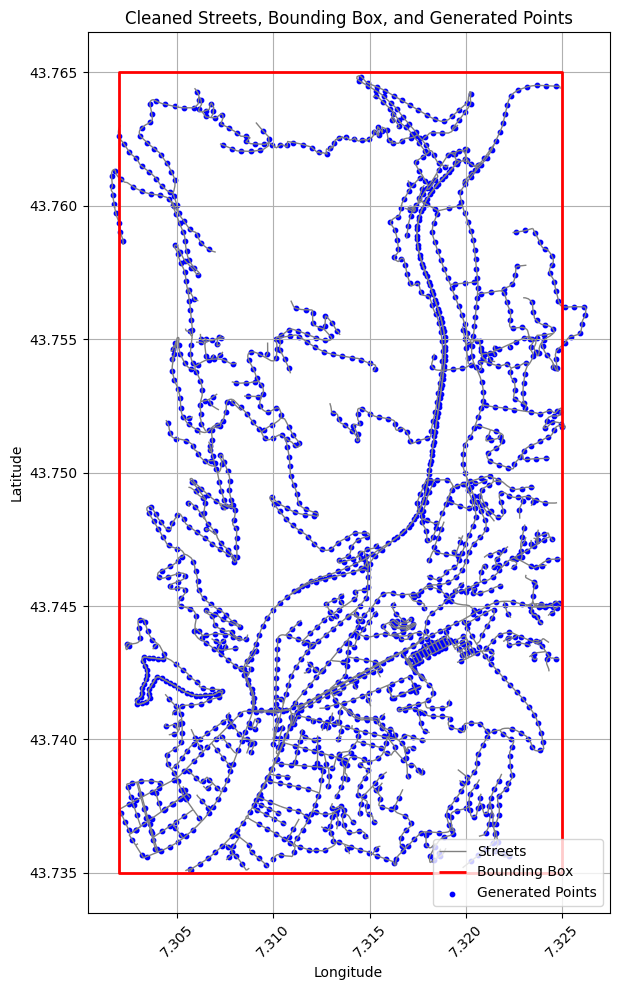

✅ Number of street segments: 955
✅ Total street length: 141.31 km
✅ Total number of points: 1898
✅ Bounding box surface: 6.18 km²
✅ Review the combined visualization. If correct, proceed with the save.


In [ ]:
# ----------------------- VISUALIZATION BLOCK -----------------------

# Count number of streets and points
num_streets = len(streets_gdf)
num_points = len(points_gdf)

# Plot streets, bounding box, and points
fig, ax = plt.subplots(figsize=(10, 10))

# Plot streets
streets_gdf.to_crs("EPSG:4326").plot(ax=ax, linewidth=1, edgecolor='gray', label='Streets')

# Plot bounding box
polygon.boundary.plot(ax=ax, color='red', linewidth=2, label='Bounding Box')

# Plot points
points_gdf.to_crs("EPSG:4326").plot(ax=ax, color='blue', markersize=10, label='Generated Points')

# Add title and axis labels
plt.title('Cleaned Streets, Bounding Box, and Generated Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.xticks(rotation=45)

# Add legend in bottom-right corner (inside plot)
ax.legend(loc='lower right', fontsize=10, frameon=True, fancybox=True)

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary in console
print(f"✅ Number of street segments: {num_streets}")
print(f"✅ Total street length: {total_length_km:.2f} km")
print(f"✅ Total number of points: {num_points}")
print(f"✅ Bounding box surface: {bbox_area_km2:.2f} km²")
print("✅ Review the combined visualization. If correct, proceed with the save.")


In [ ]:
# ----------------------- OUTPUTS -----------------------
# Save as GeoPackage in Google Drive
print(f"Saving cleaned streets and points to {save_path}")
streets_gdf = streets_gdf.to_crs(epsg=4326)
streets_gdf.to_file(save_path, layer="streets", driver="GPKG")
print("✅ Cleaned street data saved successfully!")
points_gdf.to_file(save_path, layer="points", driver="GPKG")
print("✅ Cleaned point data saved successfully!")

Saving cleaned streets and points to /content/drive/MyDrive/SAGAI/StreetSamples/nice_osm.gpkg
✅ Cleaned street data saved successfully!
✅ Cleaned point data saved successfully!
